# 05 Uudiste klasterdamine (KMeans, hierarhiline klasterdamine)

Inspiratsioon ja algallikad:
1. K-means Clustering of 1 million headlines
https://www.kaggle.com/thebrownviking20/k-means-clustering-of-1-million-headlines
2. Unsupervised - K Means Clustering Fake News (87%)
https://www.kaggle.com/nasirkhalid24/unsupervised-k-means-clustering-fake-news-87
3. Clustering
https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering
4. scipy.cluster.hierarchy.dendrogram
https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html
5. All the news Clustering 143,000 articles with KMeans.
https://towardsdatascience.com/all-the-news-17fa34b52b9d
6. STORY DISCOVERY USING K-MEANS CLUSTERING ON NEWS ARTICLES
https://seangtkelley.me/blog/2018/01/03/news-article-clustering
7. Document Clustering with Python
http://brandonrose.org/clustering

https://www.kaggle.com/gaussmake1994/word-character-n-grams-tfidf-regressions-lb-051

In [332]:
import pandas as pd
import matplotlib.pyplot as plt
from estnltk import Text

In [333]:
data_koos = pd.read_csv("data_uudised_koos_UUS.csv")
data_koos.shape

(17437, 5)

subject
Delfi              5304
Eesti Päevaleht     815
Forte                61
Maaleht              16
Telegram           5074
Uued Uudised       6000
Ärileht             167
Name: text, dtype: int64


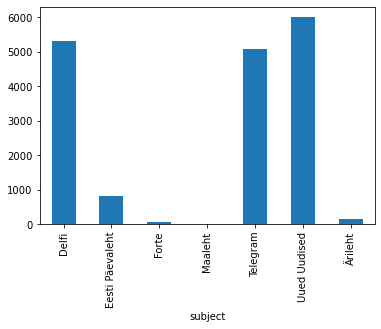

In [334]:
# Artikleid väljaannete kaupa
print(data_koos.groupby(['subject'])['text'].count())
data_koos.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

In [340]:
#https://et.wikipedia.org/wiki/Sides%C3%B5na
#https://www.taskutark.ee/m/asesonad/
#sidesõnad
punc = ['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}',"%", '“', '”', '„', '-', '’']
stopsõnad = ['ja', 'ning', 'ega', 'ehk', 'või', 'aga', 'kuid', 'ent', 'vaid', 'et', 'kui', 'kuna', 'sest', 'kuni', 'kuigi', 
             'ehkki', 'nagu', 'saati', 'elik', 'justkui', 'otsekui', 'seni']
#sidesõnad ja asesõnad
stopsõnad_uus = ['ja', 'ning', 'ega', 'ehk', 'või', 'aga', 'kuid', 'ent', 'vaid', 'et', 'kui', 'kuna', 'sest', 'kuni', 'kuigi', 
             'ehkki', 'nagu', 'saati', 'elik', 'justkui', 'otsekui', 'seni', 'siis', 'ka', 'nii', 'kas',
             'mina', 'ma', 'meie', 'me', 'sina', 'sa', 'teie', 'te', 'tema', 'ta', 'nemad', 'nad',
             'enese', 'enda', 'iseenese', 'iseenda', 'oma', 'üksteise', 'teineteise',
             'see', 'too', 'sama', 'seesama', 'toosama', 'teine', 'muu',
             'niisugune', 'samasugune', 'niisamasugune', 'selline', 'seesugune', 'säärane','säherdune', 
             'taoline', 'selletaoline', 'kes', 'mis', 'kumb', 'missugune', 'milline', 'misuke', 'mitu', 'mitmes', 'mitmendik',
             'ise', 'oma', 'iga', 'igaüks', 'igamees', 'kõik', 'mõlemad', 'kumbki', 'emb-kumb', 'kogu', 'terve',
             'keegi', 'miski', 'mingi', 'mingisugune', 'miskisugune', 'ükski', 'mitu', 'mitmes',
             'mõni', 'mõningane', 'paljud', 'üks', 'teine', 'oma', 'enese', 'enda', 'omaenese', 'omaenda', 'iseoma', 
             'iseenese', 'iseenda', 'emb', 'mõlema', 'palju', '-']
stops = stopsõnad + punc

In [341]:
# Meetod teksti sõnestamiseks estnltk abil
def tokenize_with_estnltk( input_string ):
    return Text(input_string).tag_layer(['words']).words.text

def lemmatize_with_estnltk(input_string):
    lemma = Text(input_string).tag_layer(['morph_analysis']).lemma
    # https://stackoverflow.com/questions/11264684/flatten-list-of-lists/11264799
    flattened  = [val for sublist in lemma for val in sublist]
    return flattened

In [342]:
data10000 = data_koos[:10000]

In [343]:
data10000.shape

(10000, 5)

# Klasterdamine k-keskmiste meetodil

Kood on adapteeritud http://brandonrose.org/clustering

Matemaatilistele meetoditele meeldivad struktureeritud arvandmed: vektorid ja maatriksid. Seetõttu tuleb enne statistiliste / masinõppe meetodite kasutuselevõtmist leida viis, kuidas "teisendada" oma tekstilised andmed arvandmeteks.

Tekstide automaatsel klassifitseerimisel või klasterdamisel viiakse analüüsitava korpuse dokumendid vektorkujule ehk:

luuakse iga korpuse sõna kohta vektor, mille iga positsioon kirjeldab sõna esinemist ühes korpuse dokumendis; kõigi sõnade vektoritest pannakse kokku maatriks, mille järgi saab leida nii üksiksõnade esinemismustreid kui ka dokumenti iseloomustava sõnavaramustri. Sarnasuste leidmisel tuginevadki statistilised meetodid maatriksile ning tekstide omadused, mis maatriksis ei kajastu (nt sõnade omavaheline järjekord, lausestus, süntaks vms) tulemust otseselt ka ei mõjuta.

TfidfVectorizer kasutab sõnasageduste asemel TF-IDF-skoori, mis näitab, kuivõrd iseloomulik on sõna mingile tekstile korpuses. TF (term frequency) on sõna esinemissagedus tekstis, IDF (inverse document frequency) kajastab seda, kui paljudes korpuse dokumentides see sõna üldse esineb, TF-IDF on nende korrutis.

(Eesti keele töötlus Pythonis materjal)

In [344]:
from sklearn.feature_extraction.text import TfidfVectorizer

# vektoriseerija loomine

tfidf_vectorizer = TfidfVectorizer(
                                max_df=0.8, 
                                max_features=200000,
                                min_df=0.2, 
                                stop_words=punc,
                                use_idf=True, 
                                tokenizer = lemmatize_with_estnltk,
                                ngram_range=(1,3))
%time tfidf_matrix = tfidf_vectorizer.fit_transform(data10000['text'])
print(tfidf_matrix.shape)

Wall time: 48min 29s
(10000, 137)


In [345]:
terms = tfidf_vectorizer.get_feature_names()

In [347]:
tfidf_vectorizer.vocabulary_

{'veel': 121,
 'tema': 110,
 'aga': 2,
 'üks': 132,
 'saama': 92,
 'nüüd': 71,
 'ei': 11,
 'inimene': 22,
 'kui': 41,
 'mis': 56,
 'võima': 127,
 'kõik': 47,
 'kes': 32,
 'tulema': 115,
 'riik': 89,
 'kus': 45,
 'kohta': 38,
 'kaks': 29,
 'või': 126,
 'üks üks': 133,
 'ei saama': 13,
 'kui kui': 42,
 'ei olema': 12,
 'mis mis': 57,
 'kõik kõik': 48,
 'kes kes': 33,
 'kes olema': 35,
 'kes kes olema': 34,
 'selline': 98,
 'hakkama': 20,
 'aasta': 0,
 'töö': 116,
 'võtma': 130,
 'aeg': 1,
 'oma': 81,
 'välja': 125,
 'ütlema': 135,
 'enam': 14,
 'asi': 6,
 'nagu': 65,
 'rohkem': 90,
 'siis': 100,
 'andma': 4,
 'mitte': 62,
 'juht': 26,
 'maailm': 53,
 'vastu': 120,
 'euroopa': 18,
 'ka': 28,
 'eesti': 8,
 'võimalik': 128,
 'tegema': 107,
 'üle': 134,
 'kogu': 37,
 'see et': 95,
 'olema see': 73,
 'nagu nagu': 66,
 'eest': 7,
 'vaid': 118,
 'mina': 54,
 'tahtma': 104,
 'esimene': 15,
 'miski': 61,
 'nii': 67,
 'sõna': 102,
 'suur': 101,
 'osa': 82,
 'pidama': 85,
 'kokku': 39,
 'rääkima': 

In [348]:
from sklearn.metrics.pairwise import cosine_similarity
%time dist = 1 - cosine_similarity(tfidf_matrix)

Wall time: 8.24 s


In [349]:
from sklearn.cluster import KMeans
import math

num_clusters = 3
km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

Wall time: 3min 23s


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [357]:
# sageduasemad sõnad klastrites
common_words = km.cluster_centers_.argsort()[:,-1:-50:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(terms[word] for word in centroid))

0 : mis, kes, eesti, ning, tema, üks, aasta, kui, mis mis, ka, teine, ei, inimene, riik, euroopa, saama, ütlema, kes kes, oma, pidama, teatama, kõik, mina, valitsus, uus, üks üks, kui kui, üle, sõna, tegema, tulema, teine teine, andma, ise, toimetama, aga, allikas, eest, võtma, võima, kaks, kus, või, kuid, toimuma, aeg, kokku, vastu, välja
1 : kui, mis, tema, ei, mina, kui kui, kes, mis mis, üks, ka, kõik, teine, saama, inimene, ning, oma, siis, nagu, ise, kes kes, aga, pidama, või, tegema, aasta, eesti, ütlema, võima, nii, üks üks, tulema, ei olema, riik, see olema, palju, kas, teine teine, andma, võtma, kuid, mitte, olema see, valitsus, selline, aeg, kus, juba, välja, see olema olema
2 : olnud, olnud olnud, mis, kui, kes, tema, ei, olnud olema, olnud olnud olema, olnud olnud olnud, üks, inimene, mina, mis mis, ka, aasta, ning, kui kui, teine, eesti, saama, kes kes, ütlema, oma, kõik, tegema, riik, pidama, aga, valitsus, üks üks, nagu, tulema, ise, sõna, ei olema, või, nii, aeg, võima

In [358]:
clusters = km.labels_.tolist()

data10000['cluster'] = clusters

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [359]:
import numpy as np
print("Top terms per cluster:")
print()

# sorteerimine
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d subject:" % i, end='')
    for subject in data10000[data10000['cluster'] == i]['subject'].values.tolist():
        print(' - %s' % subject)

Top terms per cluster:



Cluster 0 subject:
 - Telegram
 - Delfi
 - Uued Uudised
 - Eesti Päevaleht
 - Delfi
 - Uued Uudised
 - Uued Uudised
 - Delfi
 - Delfi
 - Delfi
 - Telegram
 - Delfi
 - Maaleht
 - Telegram
 - Delfi
 - Uued Uudised
 - Telegram
 - Uued Uudised
 - Delfi
 - Delfi
 - Telegram
 - Uued Uudised
 - Uued Uudised
 - Uued Uudised
 - Delfi
 - Delfi
 - Delfi
 - Uued Uudised
 - Telegram
 - Ärileht
 - Delfi
 - Delfi
 - Telegram
 - Uued Uudised
 - Delfi
 - Telegram
 - Delfi
 - Telegram
 - Telegram
 - Uued Uudised
 - Telegram
 - Telegram
 - Delfi
 - Telegram
 - Telegram
 - Uued Uudised
 - Delfi
 - Delfi
 - Delfi
 - Telegram
 - Delfi
 - Eesti Päevaleht
 - Delfi
 - Delfi
 - Delfi
 - Delfi
 - Uued Uudised
 - Delfi
 - Eesti Päevaleht
 - Delfi
 - Delfi
 - Telegram
 - Uued Uudised
 - Eesti Päevaleht
 - Telegram
 - Delfi
 - Telegram
 - Delfi
 - Telegram
 - Telegram
 - Delfi
 - Delfi
 - Telegram
 - Uued Uudised
 - Telegram
 - Telegram
 - Delfi
 - Uued Uudised
 - Delfi
 - Telegram
 - Uued

 - Uued Uudised
 - Delfi
 - Telegram
 - Uued Uudised
 - Uued Uudised
 - Telegram
 - Telegram
 - Uued Uudised
 - Telegram
 - Uued Uudised
 - Uued Uudised
 - Telegram
 - Telegram
 - Uued Uudised
 - Delfi
 - Delfi
 - Uued Uudised
 - Eesti Päevaleht
 - Delfi
 - Uued Uudised
 - Uued Uudised
 - Uued Uudised
 - Uued Uudised
 - Telegram
 - Uued Uudised
 - Uued Uudised
 - Delfi
 - Telegram
 - Eesti Päevaleht
 - Delfi
 - Uued Uudised
 - Uued Uudised
 - Delfi
 - Delfi
 - Delfi
 - Uued Uudised
 - Uued Uudised
 - Telegram
 - Telegram
 - Delfi
 - Delfi
 - Delfi
 - Delfi
 - Telegram
 - Uued Uudised
 - Uued Uudised
 - Telegram
 - Uued Uudised
 - Delfi
 - Telegram
 - Delfi
 - Uued Uudised
 - Telegram
 - Delfi
 - Telegram
 - Delfi
 - Telegram
 - Delfi
 - Telegram
 - Telegram
 - Uued Uudised
 - Uued Uudised
 - Delfi
 - Telegram
 - Delfi
 - Telegram
 - Delfi
 - Telegram
 - Delfi
 - Telegram
 - Ärileht
 - Telegram
 - Telegram
 - Telegram
 - Telegram
 - Telegram
 - Delfi
 - Delfi
 - Delfi
 - Uued Uudised
 -

 - Telegram
 - Telegram
 - Telegram
 - Delfi
 - Telegram
 - Eesti Päevaleht
 - Telegram
 - Delfi
 - Uued Uudised
 - Telegram
 - Telegram
 - Uued Uudised
 - Uued Uudised
 - Telegram
 - Delfi
 - Eesti Päevaleht
 - Uued Uudised
 - Uued Uudised
 - Delfi
 - Delfi
 - Delfi
 - Delfi
 - Telegram
 - Eesti Päevaleht
 - Uued Uudised
 - Uued Uudised
 - Ärileht
 - Uued Uudised
 - Delfi
 - Delfi
 - Delfi
 - Uued Uudised
 - Delfi
 - Uued Uudised
 - Telegram
 - Uued Uudised
 - Delfi
 - Telegram
 - Delfi
 - Uued Uudised
 - Uued Uudised
 - Delfi
 - Uued Uudised
 - Delfi
 - Uued Uudised
 - Telegram
 - Delfi
 - Telegram
 - Delfi
 - Eesti Päevaleht
 - Uued Uudised
 - Delfi
 - Uued Uudised
 - Telegram
 - Telegram
 - Telegram
 - Telegram
 - Delfi
 - Uued Uudised
 - Uued Uudised
 - Delfi
 - Telegram
 - Telegram
 - Delfi
 - Telegram
 - Telegram
 - Delfi
 - Delfi
 - Delfi
 - Delfi
 - Uued Uudised
 - Telegram
 - Uued Uudised
 - Uued Uudised
 - Delfi
 - Uued Uudised
 - Telegram
 - Telegram
 - Delfi
 - Uued Uudise

 - Delfi
 - Telegram
 - Uued Uudised
 - Uued Uudised
 - Delfi
 - Telegram
 - Delfi
 - Uued Uudised
 - Delfi
 - Uued Uudised
 - Telegram
 - Uued Uudised
 - Uued Uudised
 - Telegram
 - Delfi
 - Telegram
 - Uued Uudised
 - Uued Uudised
 - Telegram
 - Uued Uudised
 - Uued Uudised
 - Uued Uudised
 - Telegram
 - Delfi
 - Telegram
 - Delfi
 - Telegram
 - Uued Uudised
 - Delfi
 - Telegram
 - Telegram
 - Delfi
 - Uued Uudised
 - Uued Uudised
 - Forte
 - Uued Uudised
 - Telegram
 - Telegram
 - Telegram
 - Delfi
 - Delfi
 - Telegram
 - Delfi
 - Telegram
 - Telegram
 - Uued Uudised
 - Uued Uudised
 - Delfi
 - Ärileht
 - Uued Uudised
 - Delfi
 - Uued Uudised
 - Delfi
 - Telegram
 - Uued Uudised
 - Uued Uudised
 - Uued Uudised
 - Uued Uudised
 - Delfi
 - Uued Uudised
 - Telegram
 - Telegram
 - Eesti Päevaleht
 - Uued Uudised
 - Telegram
 - Telegram
 - Uued Uudised
 - Telegram
 - Uued Uudised
 - Telegram
 - Uued Uudised
 - Delfi
 - Uued Uudised
 - Uued Uudised
 - Telegram
 - Delfi
 - Uued Uudised
 - 

 - Uued Uudised
 - Uued Uudised
 - Telegram
 - Telegram
 - Delfi
 - Uued Uudised
 - Uued Uudised
 - Uued Uudised
 - Telegram
 - Uued Uudised
 - Uued Uudised
 - Eesti Päevaleht
 - Delfi
 - Delfi
 - Telegram
 - Telegram
 - Telegram
 - Delfi
 - Delfi
 - Uued Uudised
 - Telegram
 - Telegram
 - Delfi
 - Uued Uudised
 - Delfi
 - Ärileht
 - Uued Uudised
 - Telegram
 - Delfi
 - Delfi
 - Uued Uudised
 - Uued Uudised
 - Delfi
 - Delfi
 - Uued Uudised
 - Uued Uudised
 - Delfi
 - Uued Uudised
 - Delfi
 - Telegram
 - Uued Uudised
 - Uued Uudised
 - Delfi
 - Telegram
 - Delfi
 - Uued Uudised
 - Telegram
 - Uued Uudised
 - Telegram
 - Telegram
 - Uued Uudised
 - Delfi
 - Telegram
 - Delfi
 - Telegram
 - Delfi
 - Telegram
 - Telegram
 - Eesti Päevaleht
 - Uued Uudised
 - Telegram
 - Telegram
 - Delfi
 - Delfi
 - Delfi
 - Telegram
 - Uued Uudised
 - Telegram
 - Telegram
 - Delfi
 - Uued Uudised
 - Delfi
 - Telegram
 - Uued Uudised
 - Delfi
 - Telegram
 - Uued Uudised
 - Uued Uudised
 - Uued Uudised
 - 

 - Eesti Päevaleht
 - Uued Uudised
 - Delfi
 - Delfi
 - Uued Uudised
 - Uued Uudised
 - Delfi
 - Delfi
 - Delfi
 - Telegram
 - Uued Uudised
 - Eesti Päevaleht
 - Delfi
 - Telegram
 - Delfi
 - Uued Uudised
 - Delfi
 - Delfi
 - Delfi
 - Delfi
 - Uued Uudised
 - Eesti Päevaleht
 - Ärileht
 - Telegram
 - Telegram
 - Delfi
 - Delfi
 - Delfi
 - Uued Uudised
 - Uued Uudised
 - Delfi
 - Telegram
 - Telegram
 - Telegram
 - Delfi
 - Uued Uudised
 - Uued Uudised
 - Delfi
 - Delfi
 - Telegram
 - Telegram
 - Delfi
 - Uued Uudised
 - Delfi
 - Delfi
 - Uued Uudised
 - Uued Uudised
 - Uued Uudised
 - Delfi
 - Uued Uudised
 - Forte
 - Uued Uudised
 - Uued Uudised
 - Uued Uudised
 - Delfi
 - Delfi
 - Delfi
 - Uued Uudised
 - Uued Uudised
 - Telegram
 - Uued Uudised
 - Ärileht
 - Telegram
 - Delfi
 - Telegram
 - Telegram
 - Uued Uudised
 - Eesti Päevaleht
 - Uued Uudised
 - Delfi
 - Delfi
 - Delfi
 - Uued Uudised
 - Delfi
 - Delfi
 - Uued Uudised
 - Eesti Päevaleht
 - Uued Uudised
 - Delfi
 - Eesti Päeva

In [360]:
# klastri värvid
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3'}

# klastri nimi
cluster_names = {0: 'Klaster 1', 
                 1: 'Klaster 2', 
                 2: 'Klaster 3', }

In [361]:
import os  

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

%time pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

Wall time: 2h 50min 22s


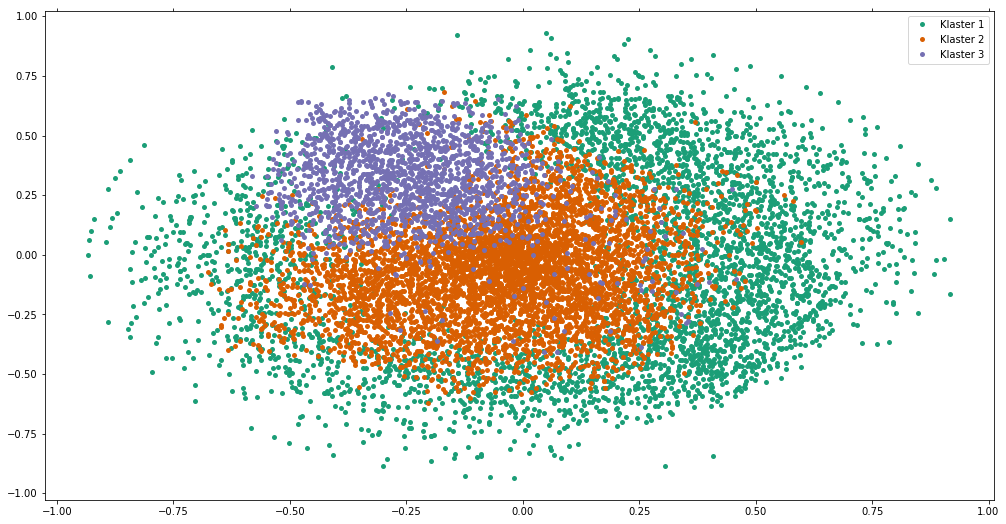

<Figure size 432x288 with 0 Axes>

In [362]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, subject=data10000.subject)) 

#group by cluster
groups = df.groupby('label')



fig, ax = plt.subplots(figsize=(17, 9)) 
ax.margins(0.05) 
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=5, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point
plt.show() #show the plot

In [376]:
# väljaannete nimed klastrite kaupa listides
klaster1 = []
klaster2 = []
klaster3 = []
for i in range(num_clusters):
  
    for subject in data10000[data10000['cluster'] == i]['subject'].values.tolist():
        if i == 0:
            klaster1.append(subject)
        if i == 1:
            klaster2.append(subject)
        if i == 2:
            klaster3.append(subject)

In [377]:
# väljaannete sagedused klastrite kaupa
import collections

ctr1 = collections.Counter(klaster1)
ctr2 = collections.Counter(klaster2)
ctr3 = collections.Counter(klaster3)
print("Klaster 1 sagedused : ",ctr1, len(klaster1))
print("Klaster 2 sagedused : ",ctr2, len(klaster2))
print("Klaster 3 sagedused : ",ctr3, len(klaster3))

Klaster 1 sagedused :  Counter({'Delfi': 1380, 'Telegram': 1079, 'Uued Uudised': 1070, 'Eesti Päevaleht': 269, 'Ärileht': 43, 'Forte': 17, 'Maaleht': 3}) 3861
Klaster 2 sagedused :  Counter({'Uued Uudised': 1894, 'Telegram': 1494, 'Delfi': 1008, 'Eesti Päevaleht': 118, 'Ärileht': 28, 'Forte': 13, 'Maaleht': 4}) 4559
Klaster 3 sagedused :  Counter({'Delfi': 628, 'Uued Uudised': 547, 'Telegram': 322, 'Eesti Päevaleht': 54, 'Ärileht': 24, 'Forte': 5}) 1580


In [378]:
# sektordiagrammi loomine
import collections
import matplotlib.pyplot as plt
import numpy as np

def sektor(klaster):
    w = collections.Counter(klaster)
    # if using a Jupyter notebook, include:
    %matplotlib inline


    labels = list(w.keys())
    sizes = list(w.values())


    fig, ax = plt.subplots(figsize=[5, 5])
    ax.pie(sizes, labels=labels, autopct='%1.1f%%')
    ax.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
    #ax.set_title("Klaster")

Klaster 1


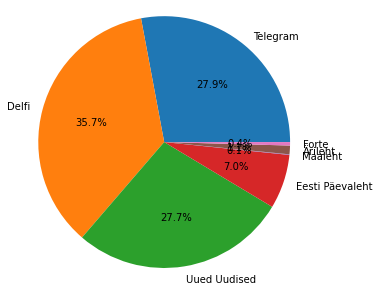

In [385]:
print("Klaster 1")
sektor(klaster1)

Klaster 2 UUED UUDISED


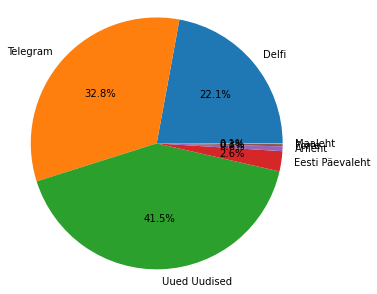

In [384]:
print("Klaster 2 UUED UUDISED")
sektor(klaster2)

Klaster 3 DELFI


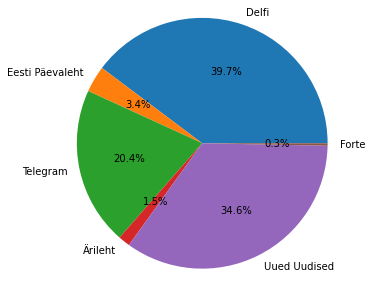

In [386]:
print("Klaster 3 DELFI")
sektor(klaster3)

In [1]:
#data10000[(data10000['cluster'] == 1) & (data10000['subject'] == 'Telegram')]['title'][300:350]

In [25]:
#data200[data200[] == 1]['text']

In [26]:
#data200[data200['cluster'] == 2]['text']

# Hierarchical document clustering
Sobib kasutada pigem väiksema andmehulga korral

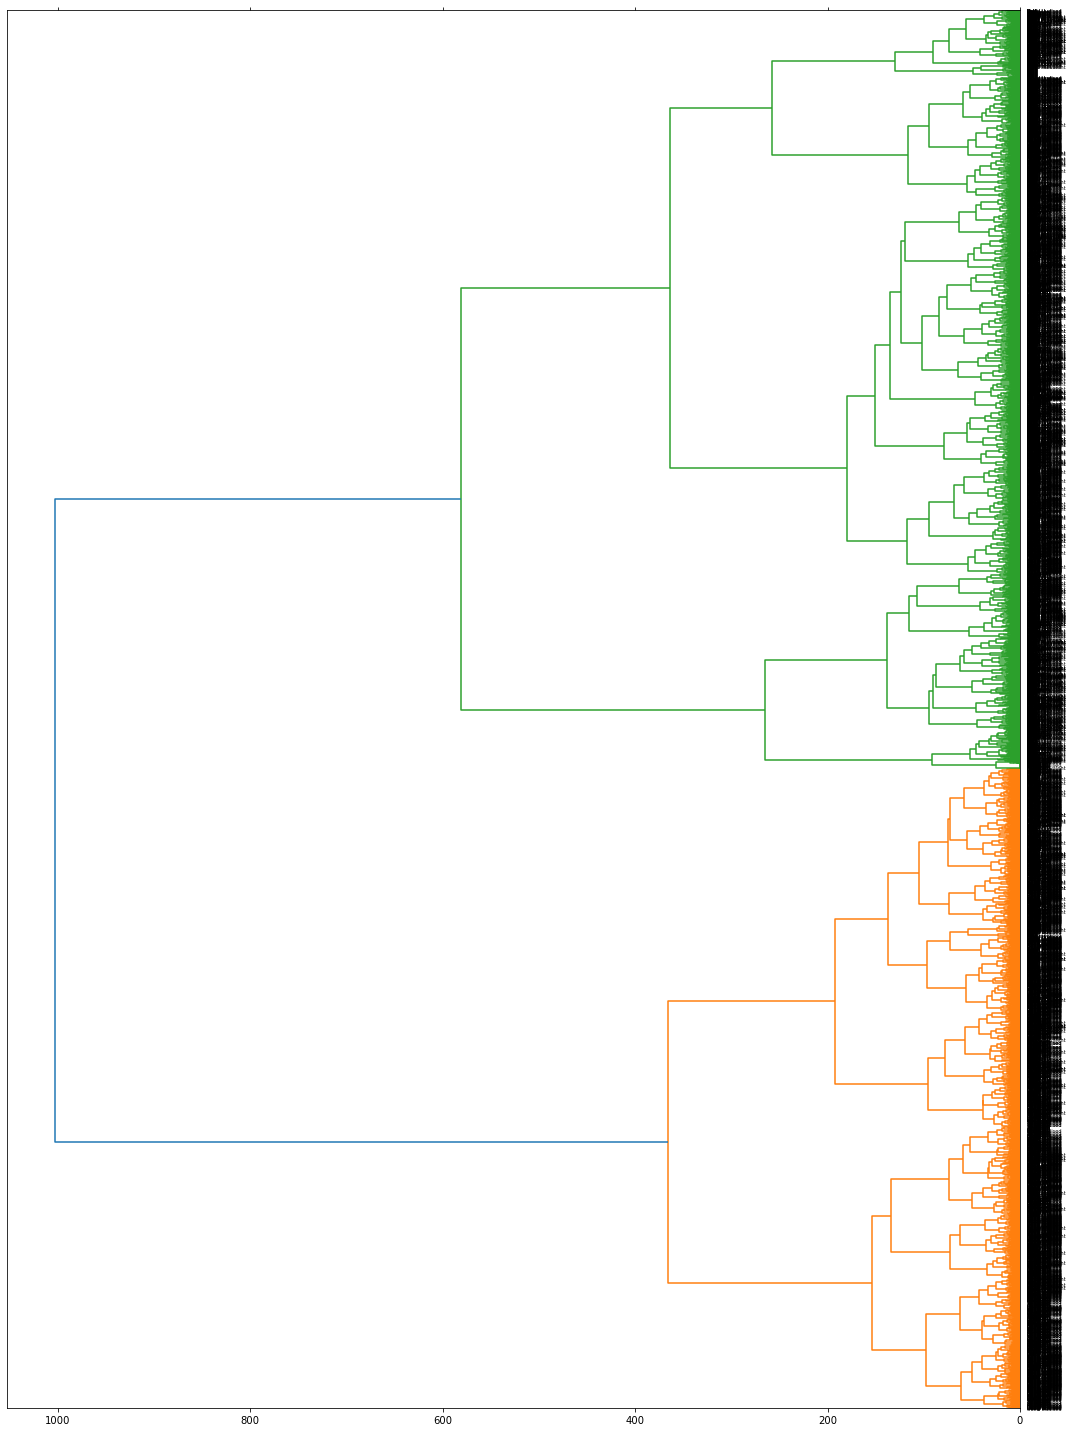

In [371]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="left", labels=(list(data10000.subject)))

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout